<a href="https://colab.research.google.com/github/Pataweepr/applyML_vistec_2019/blob/master/hw4_virus_SVMForNectec_pca_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  [SVM](https://scikit-learn.org/stable/modules/svm.html)

## [k-mer](https://en.wikipedia.org/wiki/K-mer)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import collections
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from IPython.display import display
from scipy.stats import mode

seed = 976
length = 20000
np.random.seed(seed)

import time



In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [0]:
developer_brand_downloaded = drive.CreateFile({'id': '1tb1pvtUNqx3r4FVbNsRKum2hwaLOIYmO'})
developer_brand_downloaded.GetContentFile('Chosen_Data_clearToN.csv')
df = pd.read_csv("Chosen_Data_clearToN.csv")

In [4]:
df = df[["Sequences", "Label"]]
df.head()

,Sequences,Label
0,AGCCAGGGACGTGTTGTATCCTNGGCAGTGGCCCACCCATAGGTCA...,hku
1,TGGGGATTGTGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATC...,hku
2,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku
3,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku
4,GACAAAGTTCAAAAATATATATATATATATTTTTTGCAACTCCTAG...,hku


In [5]:
key_virus = df["Label"].value_counts().index
print(key_virus)

Index(['mers', 'sars', 'hku', 'oc43', 'nl63', '229e'], dtype='object')


In [0]:
def splitTrainTest(data):
  keyDatas = data["Label"].value_counts().keys()
  train = pd.DataFrame()
  valid = pd.DataFrame()
  test = pd.DataFrame()
  chk = 0
  for k in keyDatas:
    tmp = data[data["Label"]==k]
    tmp_train, tmp_test = train_test_split(tmp, test_size=2/5, random_state=seed)
    tmp_train, tmp_valid = train_test_split(tmp_train, test_size=1/6, random_state=seed)
    train = train.append(tmp_train)
    valid = valid.append(tmp_valid)
    test = test.append(tmp_test)
  return train, valid, test

In [0]:
df_train, df_valid, df_test = splitTrainTest(df)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

'the code you want to test stays here'

## [itertools.product](https://www.hackerrank.com/challenges/itertools-product/problem)

In [0]:
def createGram(sequence, gram=5):
  nGram = dict.fromkeys(["".join(x) for x in itertools.product("ACTG",repeat=gram) ],0)
  for i in  range(len(sequence)-gram+1):
    if "N" not in str([sequence[i:i+gram]]):
      nGram[sequence[i:i+gram]]+=1
#     return np.array(list(nGram.values()))/((len(sequence)-gram+1))
  return np.array(list(nGram.values()))

def createFrequence(data, gram=5, length=10000, train=False):
  frequence = []
  label = []

  if(train):
    ### Upsampling
    max_sam = data["Label"].value_counts()[0]
    for i in data["Label"].value_counts().keys():
      tmp_virus = data[data["Label"]==i]
      tmp_virus = tmp_virus.reset_index(drop=True)
      for j in range(0, max_sam//len(tmp_virus)):
        for k in range(len(tmp_virus)):
          if(len(tmp_virus["Sequences"][k])-length == 0):
            rand_int = 0
          else:
            rand_int = np.random.randint(len(tmp_virus["Sequences"][k])-length)
          selected_sequence = tmp_virus["Sequences"][k][rand_int:rand_int+length]
          frequence.append(createGram(tmp_virus["Sequences"][k]))
          label.append(i)
  else:
    for k in range(len(data)):
      if (len(data["Sequences"][k])-length == 0) :
        rand_int = 0
      else:
        rand_int = np.random.randint(len(data["Sequences"][k])-length)
      selected_sequence = data["Sequences"][k][rand_int:rand_int+length]
    #             frequence.append(createGram(selected_sequence))
      frequence.append(createGram(data["Sequences"][k]))
      label.append(data["Label"][k])

  return np.array(frequence), label

In [0]:
X_train, y_train = createFrequence(df_train, 5, length, True)
X_valid, y_valid = createFrequence(df_valid, 5, length, False)
X_test, y_test = createFrequence(df_test, 5, length, False)

In [0]:
def buildLabel(y_str_label,key_virus_label):
  nplabel = []
  for lab in y_str_label:
    for i in np.arange(len(key_virus_label)):
      if(lab == key_virus_label[i]):
        nplabel.append(i+1)
        break
  return np.array(nplabel)

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evluate(y_pred,y_test):
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='macro') 
  prec = precision_score(y_test, y_pred, average='macro') 
  recall = recall_score(y_test, y_pred, average='macro') 
  return acc, f1, prec, recall

In [0]:
y_train = buildLabel(y_train,key_virus)
y_valid = buildLabel(y_valid,key_virus)
y_test = buildLabel(y_test,key_virus)
# print(y_train)

In [14]:
pd.Series(y_train).value_counts()

1    220
5    217
4    207
6    204
3    168
2    160
dtype: int64

In [0]:
X_train, y_train = shuffle(X_train, y_train, random_state=seed)

In [16]:
end = time.time()
print(end - start)

44.69570279121399


In [17]:
from sklearn.svm import SVC

clf_Linear = SVC(kernel='linear')
clf_Linear.fit(X_train, y_train)
y_pred_linear = clf_Linear.predict(X_test)

acc, f1, precision, recall = evluate(y_pred_linear,y_test)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

accuracy : 0.951063829787234
f1 : 0.95802280066015
precision : 0.9595498663295273
recall : 0.9566570684217743


In [18]:
clf_poly = SVC(kernel='poly')
clf_poly.fit(X_train, y_train)
y_pred_poly = clf_poly.predict(X_test)

acc, f1, precision, recall = evluate(y_pred_poly,y_test)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy : 0.948936170212766
f1 : 0.9546940563646354
precision : 0.9599029014701724
recall : 0.9499117304264363


In [19]:
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)

acc, f1, precision, recall = evluate(y_pred_rbf,y_test)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy : 0.9191489361702128
f1 : 0.8992588522588522
precision : 0.9338688610240334
recall : 0.8794334342128459


---

## 8000-10000

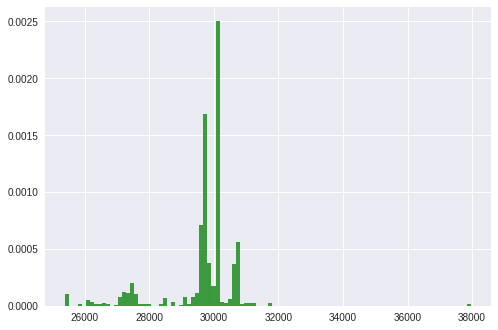

In [20]:
df_cut = df.copy()
len_Sequences = [len(x) for x in df_cut['Sequences'].values]
df_cut['len_Sequences'] = len_Sequences
n, bins, patches = plt.hist(np.array(len_Sequences), 100, density=True, facecolor='g', alpha=0.75)
plt.show()

In [0]:
sub_Sequences = [x[8000:10001] for x in df_cut['Sequences'].values]
df_cut['sub_Sequences'] = sub_Sequences
df_cut = df_cut[['sub_Sequences','Label','len_Sequences']]

In [22]:
display(df_cut.head())

,sub_Sequences,Label,len_Sequences
0,ATTGACGGATGAAAGTTGTAATAACTTGGTGCCAACATATTTGAAG...,hku,30851
1,ATGCTTTAATAGCAACTGCGCATTCTTCTATAAAACAGGGTACGCA...,hku,31041
2,CAGTTGTACACACCACCTAAATTTGCAGTTGTTCAGAGTCTTAAGA...,hku,25422
3,CTAAATTTGCAGTTGTTCAGAGTCTTAAGACCAAGCTGCAAGCAGG...,hku,25406
4,TGGTAAGTACAAAGGTGAACAATGGGCCCATATGGTATCCATTGCT...,hku,26162


In [0]:
df_cut.rename(columns={'sub_Sequences': 'Sequences'}, inplace=True)

df_cut_train, df_cut_valid, df_cut_test = splitTrainTest(df_cut)
df_cut_train = df_cut_train.reset_index(drop=True)
df_cut_valid = df_cut_valid.reset_index(drop=True)
df_cut_test = df_cut_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createFrequence(df_cut_train, 5, 2000, True)
X_valid_key_seq, y_valid_key_seq = createFrequence(df_cut_valid, 5, 2000, False)
X_test_key_seq, y_test_key_seq = createFrequence(df_cut_test, 5, 2000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)

In [24]:
pd.Series(y_train.reshape(-1)).value_counts()

1    220
5    217
4    207
6    204
3    168
2    160
dtype: int64

In [25]:
clf = SVC(kernel ='poly')
clf.fit(X_train_key_seq, y_train_key_seq)
y_pred = clf.predict(X_test_key_seq)

acc, f1, precision, recall = evluate(y_pred,y_test_key_seq)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy : 0.9659574468085106
f1 : 0.9702082228353007
precision : 0.9738577378180077
recall : 0.9672991224461812


------

## 8000-10000

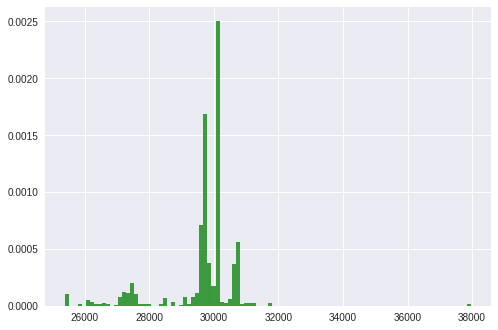

In [51]:
df_cut = df.copy()
len_Sequences = [len(x) for x in df_cut['Sequences'].values]
df_cut['len_Sequences'] = len_Sequences
n, bins, patches = plt.hist(np.array(len_Sequences), 100, density=True, facecolor='g', alpha=0.75)
plt.show()

In [52]:
display(df_cut.head())

,Sequences,Label,len_Sequences
0,AGCCAGGGACGTGTTGTATCCTNGGCAGTGGCCCACCCATAGGTCA...,hku,30851
1,TGGGGATTGTGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATC...,hku,31041
2,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku,25422
3,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku,25406
4,GACAAAGTTCAAAAATATATATATATATATTTTTTGCAACTCCTAG...,hku,26162


In [0]:
sub_Sequences = [x for x in df_cut['Sequences'].values]
df_cut['sub_Sequences'] = sub_Sequences
df_cut = df_cut[['sub_Sequences','Label','len_Sequences']]

In [54]:
df_cut.rename(columns={'sub_Sequences': 'Sequences'}, inplace=True)

df_cut_train, df_cut_valid, df_cut_test = splitTrainTest(df_cut)
df_cut_train = df_cut_train.reset_index(drop=True)
df_cut_valid = df_cut_valid.reset_index(drop=True)
df_cut_test = df_cut_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createFrequence(df_cut_train, 5, 2000, True)
X_valid_key_seq, y_valid_key_seq = createFrequence(df_cut_valid, 5, 2000, False)
X_test_key_seq, y_test_key_seq = createFrequence(df_cut_test, 5, 2000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)

df_cut.head()


,Sequences,Label,len_Sequences
0,AGCCAGGGACGTGTTGTATCCTNGGCAGTGGCCCACCCATAGGTCA...,hku,30851
1,TGGGGATTGTGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATC...,hku,31041
2,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku,25422
3,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku,25406
4,GACAAAGTTCAAAAATATATATATATATATTTTTTGCAACTCCTAG...,hku,26162


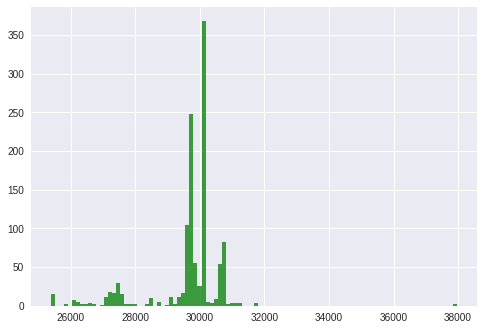

[30851, 31041, 25422, 25406, 26162, 26155, 30497, 30498, 30119, 30119, 30119, 30048, 30039, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30121, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123, 30123

In [55]:
len_Sequences = [len(x) for x in df_cut['Sequences'].values]
n, bins, patches = plt.hist(np.array(len_Sequences), 100, facecolor='g', alpha=0.75)
plt.show()
print(len_Sequences)

In [57]:
clf = SVC()
clf.fit(X_train_key_seq, y_train_key_seq)
y_pred = clf.predict(X_test_key_seq)

acc, f1, precision, recall = evluate(y_pred,y_test_key_seq)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy : 0.9191489361702128
f1 : 0.8992588522588522
precision : 0.9338688610240334
recall : 0.8794334342128459


------

In [0]:
df_train, df_valid, df_test = splitTrainTest(df)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train_key_seq, y_train_key_seq = createFrequence(df_train, 5, 20000, True)
X_valid_key_seq, y_valid_key_seq = createFrequence(df_valid, 5, 20000, False)
X_test_key_seq, y_test_key_seq = createFrequence(df_test, 5, 20000, False)

y_train_key_seq = buildLabel(y_train_key_seq,key_virus)
y_valid_key_seq = buildLabel(y_valid_key_seq,key_virus)
y_test_key_seq = buildLabel(y_test_key_seq,key_virus)

X_train_key_seq, y_train_key_seq = shuffle(X_train_key_seq, y_train_key_seq, random_state=seed)

train_acc = [] 
test_acc = []
number_sv = []
runtime = []
range_c = 200
for log_c in np.arange(0,6,6/range_c):
  c = np.exp(log_c)
  clf = SVC(C=c,gamma ='auto')
  start_time = time.time()
  clf.fit(X_train_key_seq, y_train_key_seq)
  end_time = time.time()
  y_pred_train = clf.predict(X_train_key_seq)
  y_pred = clf.predict(X_test_key_seq)
  
  number_sv.append(np.sum(clf.n_support_))
  acc_train, _, _, _ = evluate(y_pred_train,y_train_key_seq)
  acc_test, _, _, _ = evluate(y_pred,y_test_key_seq)
  train_acc.append(acc_train)
  test_acc.append(acc_test)
  runtime.append(end_time - start_time)

In [79]:
number_sv

[283,
 281,
 280,
 280,
 280,
 280,
 279,
 278,
 278,
 278,
 278,
 279,
 279,
 277,
 277,
 277,
 277,
 276,
 270,
 270,
 270,
 270,
 270,
 270,
 271,
 272,
 272,
 272,
 273,
 273,
 273,
 274,
 274,
 274,
 274,
 274,
 275,
 275,
 275,
 276,
 277,
 277,
 277,
 277,
 277,
 277,
 277,
 277,
 278,
 278,
 279,
 280,
 280,
 280,
 281,
 282,
 283,
 284,
 284,
 284,
 285,
 285,
 287,
 287,
 287,
 288,
 289,
 289,
 288,
 288,
 288,
 289,
 290,
 289,
 291,
 290,
 293,
 291,
 297,
 288,
 288,
 288,
 288,
 288,
 288,
 294,
 287,
 287,
 287,
 287,
 287,
 287,
 287,
 287,
 288,
 288,
 288,
 288,
 287,
 287,
 287,
 286,
 286,
 286,
 286,
 286,
 285,
 285,
 287,
 286,
 286,
 286,
 286,
 286,
 285,
 286,
 286,
 286,
 286,
 286,
 286,
 286,
 285,
 285,
 285,
 285,
 284,
 283,
 283,
 283,
 283,
 283,
 283,
 283,
 282,
 282,
 282,
 282,
 281,
 281,
 281,
 280,
 279,
 279,
 279,
 279,
 279,
 279,
 279,
 279,
 279,
 280,
 280,
 279,
 279,
 278,
 278,
 278,
 277,
 277,
 277,
 277,
 276,
 276,
 276,
 276,
 276

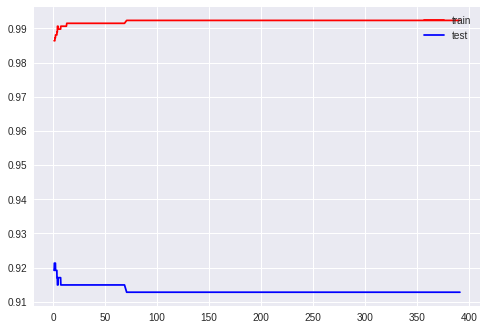

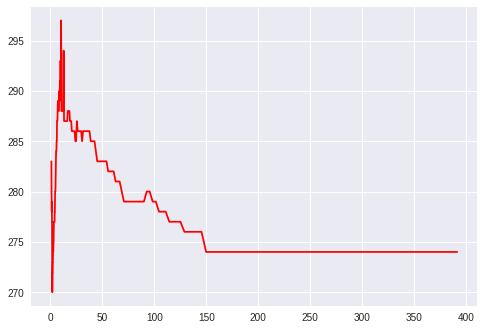

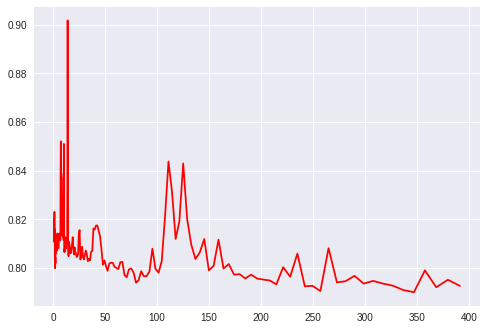

In [78]:
domain_c = np.arange(0,6,6/range_c)
domain_c = np.exp(domain_c)
plt.plot(domain_c, np.array(train_acc), 'r', domain_c, np.array(test_acc), 'b')
plt.legend(('train', 'test'),loc='upper right')
plt.show()

plt.plot(domain_c, np.array(number_sv), 'r')
plt.show()

plt.plot(domain_c, np.array(runtime), 'r')
plt.show()

----

## creted data majority

In [0]:
num_sub_seq = 5
len_sub_seq = int(length/num_sub_seq)
df_majority = df.copy()

for i in np.arange(num_sub_seq):
  sub_seq_name ='sub_Sequences_'+ str(i)
  sub_Sequences = [x[i*len_sub_seq:(i+1)*len_sub_seq] for x in df_majority['Sequences'].values]
  df_majority[sub_seq_name] = sub_Sequences

## majority vote

In [34]:
X_train_major = []
y_train_major = []
X_valid_major = []
y_valid_major = []
X_test_major = []
y_test_major = []

svc_sub_seq = []

y_pred_val_major = []
y_pred_test_major = []


for i in np.arange(num_sub_seq):
  
  sub_seq_name ='sub_Sequences_'+ str(i)
  
  df_cut_maj = df_majority[[sub_seq_name,'Label']].copy()
  df_cut_maj.rename(columns={ sub_seq_name : 'Sequences'}, inplace=True)
  
  df_majority_train,df_majority_valid, df_majority_test = splitTrainTest(df_cut_maj)
  df_majority_train = df_majority_train.reset_index(drop=True)
  df_majority_valid = df_majority_valid.reset_index(drop=True)
  df_majority_test = df_majority_test.reset_index(drop=True)
  
  X_train_A, y_train_A = createFrequence(df_majority_train, 5, len_sub_seq, True)
  X_valid_A, y_valid_A = createFrequence(df_majority_valid, 5, len_sub_seq, False)
  X_test_A, y_test_A = createFrequence(df_majority_test, 5, len_sub_seq, False)
  y_train_A = buildLabel(y_train_A,key_virus)
  y_valid_A = buildLabel(y_valid_A,key_virus)
  y_test_A = buildLabel(y_test_A,key_virus)

  X_train_A, y_train_A = shuffle(X_train_A, y_train_A, random_state=seed)
  
  X_train_major.append(X_train_A)
  X_valid_major.append(X_valid_A)
  X_test_major.append(X_test_A)
  
  if(i == 0):
    y_train_major.append(y_train_A)
    y_valid_major.append(y_valid_A)
    y_test_major.append(y_test_A)
  
  
  clf = SVC()
  clf.fit(X_train_major[i], y_train_major[0].reshape(-1))
  svc_sub_seq.append(clf)
  
  ## predict val set
  y_pred_val = clf.predict(X_valid_A)
  y_pred_test = clf.predict(X_test_A)
  
  y_pred_val_major.append(y_pred_val)
  y_pred_test_major.append(y_pred_test)
  ##

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [35]:
y_real_predict_val = []
y_real_predict_test = []

for i in np.arange(len(y_valid_major[0])):
  all_predict_val = [] 
  for j in np.arange(num_sub_seq):
    all_predict_val.append(y_pred_val_major[j][i])
    
  all_predict_val = np.array(all_predict_val) 
  y_real_predict_val.append(mode(all_predict_val)[0])
  

for i in np.arange(len(y_pred_test_major[0])):
  all_predict_test = []
  for j in np.arange(num_sub_seq):
    all_predict_test.append(y_pred_test_major[j][i])
  all_predict_test = np.array(all_predict_test)
  y_real_predict_test.append(mode(all_predict_test)[0])
  

print('val set')
acc, f1, precision, recall = evluate(y_real_predict_val,y_valid_major[0])
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)  


#print(len(y_real_predict_test))
#print(len(y_test_major[0]))

print('test set')
acc, f1, precision, recall = evluate(y_real_predict_test,y_test_major[0])
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)



val set
accuracy : 0.9747899159663865
f1 : 0.9785806785806787
precision : 0.9823369565217391
recall : 0.97534165181224
test set
accuracy : 0.9638297872340426
f1 : 0.9552771842311981
precision : 0.9693873460849524
recall : 0.9431502321208204


----

## majority vote 2

In [36]:

for i in np.arange(num_sub_seq):
  if i == 0:
    X_train_maj_merge = np.copy(X_train_major[0])
    y_train_maj_merge = list(y_train_major[0].copy())
  else:
    X_to_merge = np.copy(X_train_major[i])
    y_to_merge = y_train_major[0].copy()
    
    X_train_maj_merge = np.vstack((X_train_maj_merge,X_to_merge))
    y_train_maj_merge = y_train_maj_merge + list(y_to_merge)

#print(X_train_maj_merge.shape)
#print(len(y_train_maj_merge)) 

#print(X_train_major[0].shape)
#print(len(y_train_major[0]))
  ##

clf = SVC()
clf.fit(X_train_maj_merge, y_train_maj_merge)

#print(y_train_maj_merge)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred_val_maj = []
y_pred_test_maj = []
for i in np.arange(num_sub_seq):
  y_pred_val = clf.predict(X_valid_major[i])
  y_pred_val_maj.append(y_pred_val)
  
  y_pred_test = clf.predict(X_test_major[i])
  y_pred_test_maj.append(y_pred_test)
  

In [38]:

y_real_predict_major_val = []
y_real_predict_major_test = []

for i in np.arange(len(y_valid_major[0])):
  all_predict_val = [] 
  for j in np.arange(num_sub_seq):
    all_predict_val.append(y_pred_val_maj[j][i])
    
  all_predict_val = np.array(all_predict_val) 
  y_real_predict_major_val.append(mode(all_predict_val)[0])
  

for i in np.arange(len(y_pred_test_major[0])):
  all_predict_test = []
  for j in np.arange(num_sub_seq):
    all_predict_test.append(y_pred_test_maj[j][i])
  all_predict_test = np.array(all_predict_test)
  y_real_predict_major_test.append(mode(all_predict_test)[0])
  

print('val set')
acc, f1, precision, recall = evluate(y_real_predict_major_val,y_valid_major[0])
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)  


print(len(y_real_predict_test))
print(len(y_test_major[0]))

print('test set')
acc, f1, precision, recall = evluate(y_real_predict_major_test,y_test_major[0])
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)



val set
accuracy : 0.9747899159663865
f1 : 0.9785806785806787
precision : 0.9823369565217391
recall : 0.97534165181224
470
470
test set
accuracy : 0.9638297872340426
f1 : 0.9552771842311981
precision : 0.9693873460849524
recall : 0.9431502321208204


-----

------

In [39]:
df_majority.head()

,Sequences,Label,sub_Sequences_0,sub_Sequences_1,sub_Sequences_2,sub_Sequences_3,sub_Sequences_4
0,AGCCAGGGACGTGTTGTATCCTNGGCAGTGGCCCACCCATAGGTCA...,hku,AGCCAGGGACGTGTTGTATCCTNGGCAGTGGCCCACCCATAGGTCA...,CTGGACAGCAGTTCGTTAAAGAGACTACCGATATGGTTAAGTCTAA...,ATTGACGGATGAAAGTTGTAATAACTTGGTGCCAACATATTTGAAG...,TTGGAGCGTATGGCAGATTTGGCTCTTACTAATATGTATAAAGAAG...,AAAGCCTCTTCTTTGCTGCAAGTGTTGTTACGATCACGTTATGGCA...
1,TGGGGATTGTGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATC...,hku,TGGGGATTGTGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATC...,TTTGAAATTGCCCAATTGTATGGTTCTTGTATAACACCTAATGTAT...,ATGCTTTAATAGCAACTGCGCATTCTTCTATAAAACAGGGTACGCA...,TGAATTTGTTAATATGGCTAGCTTTGTTGAATATGAAGTTGCTAAG...,AGATCTTGGATAGCTACAGTGTTATTTTAAGTACTTGTGATGGACA...
2,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,GAACCAAGCCAAGGAACTTGACCTTAACCTTCAGCAATACTGCGTC...,CAGTTGTACACACCACCTAAATTTGCAGTTGTTCAGAGTCTTAAGA...,TCTTGTTGGCATATTAACACCCGATAATCAAGACCTCCTGGGTCAG...,CGCTGCGGCTATGAGTATAATGGCGTCCATCCAGCTCATGCTTTGA...
3,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,hku,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...,CTTGACCTTAACCTTCAGCAATACTGCGTCTACCTGAAGACTTGCC...,CTAAATTTGCAGTTGTTCAGAGTCTTAAGACCAAGCTGCAAGCAGG...,ACACCCGACAATCAAGACCTCCTGGGTCAGATCTATGACTTTGGAG...,ATAATGGCGTCCATCCAGCTCATGCTTTGACCTGGCATGATTGTGG...
4,GACAAAGTTCAAAAATATATATATATATATTTTTTGCAACTCCTAG...,hku,GACAAAGTTCAAAAATATATATATATATATTTTTTGCAACTCCTAG...,TTGCCATTGATGAACTATACCAGGAGTACAGAAATGGTAATCCCAG...,TGGTAAGTACAAAGGTGAACAATGGGCCCATATGGTATCCATTGCT...,CTATAGAGTATGATGGTTTCCAATATGACTTTACTGACTTTAAGCG...,TGAATACCGCTGTGATGAACCATTAGCCAAACTAGTAGGTGTCTCT...


In [40]:


print('sub_Sequences_' +str(8))

sub_Sequences_8


In [41]:
clf = SVC()
clf.fit(X_train, y_train.reshape(-1))
y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [42]:
acc, f1, precision, recall = evluate(y_pred,y_test)
print('accuracy :',acc)
print('f1 :',f1)
print('precision :',precision)
print('recall :',recall)

accuracy : 0.9191489361702128
f1 : 0.8992588522588522
precision : 0.9338688610240334
recall : 0.8794334342128459


---

---

---